In [1]:
from src.utils import *
import pandas as pd
from Bio.PDB import MMCIFParser
import numpy as np

#HTRA1 from uniprot
HTRA1="MQIPRAALLPLLLLLLAAPASAQLSRAGRSAPLAAGCPDRCEPARCPPQPEHCEGGRARDACGCCEVCGAPEGAACGLQEGPCGEGLQCVVPFGVPASATVRRRAQAGLCVCASSEPVCGSDANTYANLCQLRAASRRSERLHRPPVIVLQRGACGQGQEDPNSLRHKYNFIADVVEKIAPAVVHIELFRKLPFSKREVPVASGSGFIVSEDGLIVTNAHVVTNKHRVKVELKNGATYEAKIKDVDEKADIALIKIDHQGKLPVLLLGRSSELRPGEFVVAIGSPFSLQNTVTTGIVSTTQRGGKELGLRNSDMDYIQTDAIINYGNSGGPLVNLDGEVIGINTLKVTAGISFAIPSDKIKKFLTESHDRQAKGKAITKKKYIGIRMMSLTSSKAKELKDRHRDFPDVISGAYIIEVIPDTPAEAGGLKENDVIISINGQSVVSANDVSDVIKRESTLNMVVRRGNEDIMITVIPEEIDP"
db=pd.read_csv("./data/HTRA1_peptides.csv")

db

/home/ubuntu/anaconda3/envs/char2024/lib/python3.8/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


,Unnamed: 0,Peptide_Experimental,IC50_uM,IC50_std
0,0,DSRIWWV,0.9,0.1
1,1,DARIWWV,1.3,0.1
2,2,WDKIWHV,2.8,0.3
3,3,ASRIWWV,2.8,0.3
4,4,DSRIWAV,6.0,1.0
5,5,GWKTWIL,7.7,0.6
6,6,DSRAWVV,13.0,1.0
7,7,DIGPVCF,16.0,3.0
8,8,DIETWLL,23.0,3.0
9,9,EVKIMVV,24.0,8.0


### Identify Reference peptide

In [2]:
db['ESM2_initialLoss'] = db['Peptide_Experimental'].apply(lambda peptide: compute_mlm_overall_withoutTheMaskedPos(HTRA1, peptide, [], []))
# db['ESM2_initialLoss'] = db['Peptide_Experimental'].apply(lambda peptide: compute_mlm_overall(HTRA1, peptide, [], []))
db

,Unnamed: 0,Peptide_Experimental,IC50_uM,IC50_std,ESM2_initialLoss
0,0,DSRIWWV,0.9,0.1,12.804563
1,1,DARIWWV,1.3,0.1,12.691013
2,2,WDKIWHV,2.8,0.3,12.703898
3,3,ASRIWWV,2.8,0.3,12.813797
4,4,DSRIWAV,6.0,1.0,12.854457
5,5,GWKTWIL,7.7,0.6,12.810143
6,6,DSRAWVV,13.0,1.0,12.865527
7,7,DIGPVCF,16.0,3.0,12.856627
8,8,DIETWLL,23.0,3.0,12.699419
9,9,EVKIMVV,24.0,8.0,12.755946


In [3]:
min_index = db['ESM2_initialLoss'].idxmin()
reference_peptide = db.loc[min_index, 'Peptide_Experimental']
reference_peptide

'DARIWWV'

### Get the binding affinity 

In [4]:
def compute_results(row):
    peptide = row['Peptide_Experimental']
    HTRA_positions = [] 
    pep_positions = np.array(find_differences(reference_peptide, peptide)) 
    print(reference_peptide, peptide, pep_positions)
    # return compute_mlm_overall(HTRA1, reference_peptide, HTRA_positions, pep_positions)
    return compute_mlm_overall_withoutTheMaskedPos(HTRA1, reference_peptide, HTRA_positions, pep_positions)

db['ESM2_ppi_score_overall'] = db.apply(compute_results, axis=1)
db

DARIWWV DSRIWWV [1]
DARIWWV DARIWWV []
DARIWWV WDKIWHV [0 1 2 5]
DARIWWV ASRIWWV [0 1]
DARIWWV DSRIWAV [1 5]
DARIWWV GWKTWIL [0 1 2 3 5 6]
DARIWWV DSRAWVV [1 3 5]
DARIWWV DIGPVCF [1 2 3 4 5 6]
DARIWWV DIETWLL [1 2 3 5 6]
DARIWWV EVKIMVV [0 1 2 4 5]
DARIWWV DSRIAWV [1 4]


,Unnamed: 0,Peptide_Experimental,IC50_uM,IC50_std,ESM2_initialLoss,ESM2_ppi_score_overall
0,0,DSRIWWV,0.9,0.1,12.804563,12.681170
1,1,DARIWWV,1.3,0.1,12.691013,12.691013
2,2,WDKIWHV,2.8,0.3,12.703898,12.747519
3,3,ASRIWWV,2.8,0.3,12.813797,12.687531
4,4,DSRIWAV,6.0,1.0,12.854457,12.723074
5,5,GWKTWIL,7.7,0.6,12.810143,12.771887
6,6,DSRAWVV,13.0,1.0,12.865527,12.736728
7,7,DIGPVCF,16.0,3.0,12.856627,12.795417
8,8,DIETWLL,23.0,3.0,12.699419,12.764093
9,9,EVKIMVV,24.0,8.0,12.755946,12.791503


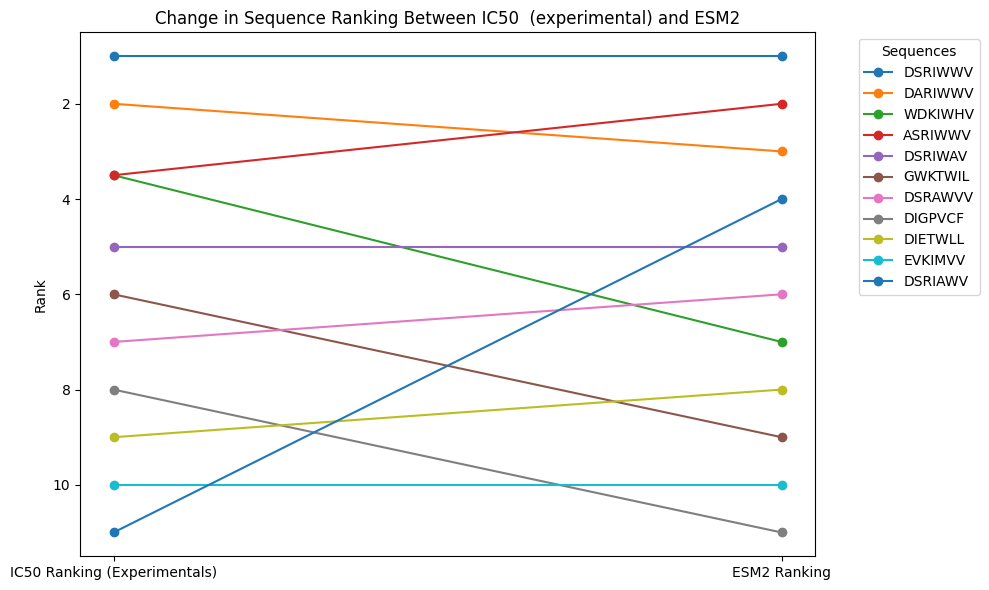

In [5]:
db['ESM2_Rank'] = db['ESM2_ppi_score_overall'].rank(ascending=True) 
db['IC50_Rank'] = db['IC50_uM'].rank(ascending=True) 


plt.figure(figsize=(10, 6))
for _, row in db.iterrows():
    plt.plot([1, 2], [row['IC50_Rank'], row['ESM2_Rank']], '-o', label=row['Peptide_Experimental'])

plt.xticks([1, 2], ['IC50 Ranking (Experimentals)', 'ESM2 Ranking'])
plt.gca().invert_yaxis()  # Invert y-axis so that lower ranks appear higher
plt.ylabel('Rank')
plt.title('Change in Sequence Ranking Between IC50  (experimental) and ESM2')
plt.legend(title="Sequences", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [6]:
from sklearn.metrics import ndcg_score
print("IC50",db["IC50_Rank"].values)
print("ESM2",db['ESM2_ppi_score_overall'].values)
ndcg_score([db["IC50_Rank"].values], [db["ESM2_ppi_score_overall"].values])

IC50 [ 1.   2.   3.5  3.5  5.   6.   7.   8.   9.  10.  11. ]
ESM2 [12.68117046 12.69101334 12.74751854 12.68753147 12.72307396 12.77188683
 12.73672771 12.79541683 12.7640934  12.79150295 12.71728992]


0.921824230188584

In [7]:
ndcg_score([db["IC50_uM"].values], [db["ESM2_ppi_score_overall"].values])

0.7784689084391242

In [8]:
from scipy.stats import kendalltau
print(db['IC50_Rank'].values.astype(int))
print(db['ESM2_Rank'].values.astype(int))
# Calculate Kendall's Tau
tau, p_value = kendalltau(db['IC50_Rank'].values.astype(int), db['ESM2_Rank'].values.astype(int))

print(f"Kendall's Tau: {tau:.2f}")
print(f"P-value: {p_value:.4f}")

[ 1  2  3  3  5  6  7  8  9 10 11]
[ 1  3  7  2  5  9  6 11  8 10  4]
Kendall's Tau: 0.48
P-value: 0.0423
